# python에서 MySQL 사용하기 

In [2]:
import mysql.connector
from mysql.connector import connect,Error
import pandas as pd

# mysql 연결 함수
def create_mysql_connection(host, user, password, database):
    try:
        connection = connect(
            host = host,
            user = user,
            password = password,
            database = database
        )

        if connection.is_connected():
            print(f'Connected to MySQL server : {host}')
        return connection
    except Error as e:
        print(f'Error: {e}')
        return None

# 쿼리 실행 함수
def execute_query(connection, query):
    df = pd.read_sql(query, connection)
    return df


# mysql 연결 종료 함수
def close_connection(connection):
    if connection:
        connection.close()
        print('Connection to MySQL closed.')



In [3]:
connection = create_mysql_connection('localhost','CLOUDY','1234','yammers')

Connected to MySQL server : localhost


In [6]:
query = " SELECT * FROM emails"

df = execute_query(connection, query)
df

,user_id,occurred_at,action,user_type
0,0.0,2014-05-06 09:30:00,sent_weekly_digest,1.0
1,0.0,2014-05-13 09:30:00,sent_weekly_digest,1.0
2,0.0,2014-05-20 09:30:00,sent_weekly_digest,1.0
3,0.0,2014-05-27 09:30:00,sent_weekly_digest,1.0
4,0.0,2014-06-03 09:30:00,sent_weekly_digest,1.0
...,...,...,...,...
90384,18814.0,2014-08-31 12:12:26,email_open,3.0
90385,18814.0,2014-08-31 12:12:57,email_clickthrough,3.0
90386,18815.0,2014-08-31 13:39:56,sent_reengagement_email,2.0
90387,18815.0,2014-08-31 13:40:14,email_open,2.0


# user추이 파악

In [56]:
query = " SELECT DATE_FORMAT(occurred_at, '%y-%m-%d') AS DATE,\
                COUNT(DISTINCT user_id) AS weekly_active_users \
                FROM events \
                WHERE event_type = 'engagement' \
                AND event_name = 'login' \
                GROUP BY 1 \
                ORDER BY 1"

user_change_df = execute_query(connection, query)
user_change_df



,DATE,weekly_active_users
0,14-05-01,293
1,14-05-02,358
2,14-05-03,145
3,14-05-04,79
4,14-05-05,257
...,...,...
118,14-08-27,301
119,14-08-28,319
120,14-08-29,397
121,14-08-30,173


- WAU를 주별로 묶기

In [57]:
# 날짜 형식 변환
user_change_df['DATE'] = pd.to_datetime(user_change_df['DATE'], format='%y-%m-%d')


user_change_df['start_of_week'] = user_change_df['DATE'] - pd.to_timedelta(user_change_df['DATE'].dt.dayofweek, unit='D')
user_change_df['end_of_week'] = user_change_df['start_of_week'] + pd.DateOffset(days=6)

In [58]:
user_change_group_df = user_change_df.groupby(['start_of_week']).sum('weekly_active_users')
user_change_group_df

,weekly_active_users
start_of_week,
2014-04-28,875
2014-05-05,1780
2014-05-12,1805
2014-05-19,1878
2014-05-26,1801
2014-06-02,1948
2014-06-09,1984
2014-06-16,2044
2014-06-23,2018


(array([16191., 16205., 16222., 16236., 16252., 16266., 16283., 16297.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

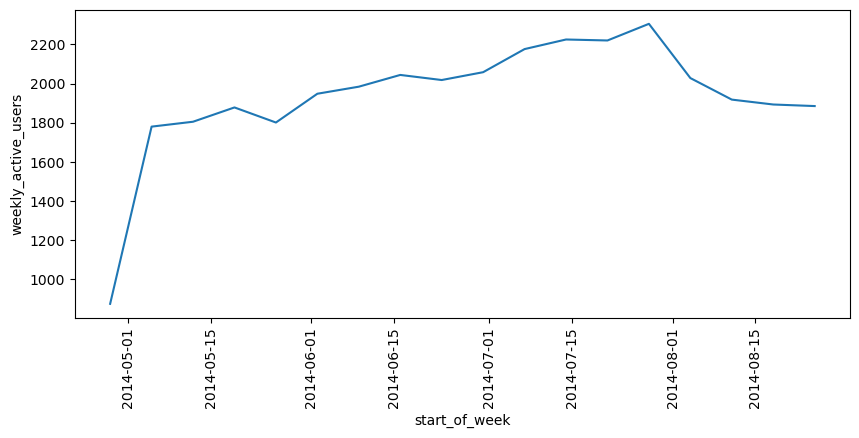

In [59]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10,4))

sns.lineplot(x=user_change_group_df.index,y=user_change_group_df.weekly_active_users )

plt.xticks(rotation=90)

- [문제] 2014년 7월 말, 8월 초부터 Weekly Active User 수가 감소하고 있다.
- 해결책을 도출해야 한다.

해결책을 도출하기 위한 분석?
- 가설을 먼저 세워야 한다.
  - 이 현상의 원인이 ~~가 있을 수 있다.
  - 이 원인들 중에서 ~~부터 파악해봐야겠다.

# 가설 & 우선순위

[가설] 아래의 이유때문에 WAU가 감소했을 가능성이 있다.
- Holiday
  - yammers는 사내 페이스북같은 기능이다.
  - 따라서, 특정 국가가 다른 국가보다 훨씬 낮은 engagement를 갖고 있다면, 해당 국가가 공휴일일 수도 있다.
- Broken Feature
  - 어플 기능이 고장나서 사람들이 사용하지 못한 것이 원인일 수도 있다.
  - 서비스 가입 기능 고장, 모바일 앱 고장
- Broken Tracking Code
  - 로그를 수집하는 코드 문제
- Traffic anomalies from bots
  - 대부분 웹사이트에서는 bot의 활동기록이 많다.
  - 제품이나 인프라가 변화해서 봇의 참여가 줄어들 수 있다.
- Traffic shutdown to your site
  - 구글, 네이버 등 internet service providers가 사이트를 차단했을 수도 있다.
- Marketing event
  - 마케팅 이벤트가 순간적으로 engagement를 펌핑했다가 떨어진 것은 아닐까? 예를 들면 superbowl 광고로 유입된 유저들은 서비스 이탈율이 높을 수도 있다.
  - 이럴 땐 marketing department 사람들에게 어떤 빅 마케팅이 있었는지 물어볼 수 있다.
- Bad data
  - QA(Quality Assurance)데이터 (사내 트래킹)를 실제 유저 데이터와 분리하지 않은 상태인데, 만약 이번주부터 QA를 안하기로 했다면 WAU가 떨어질 수도 있다.
- Search Crawler changes
  - 검색 엔진이 우리 서비스를 검색 키워드 몇위에 랭킹 시켜주는지가 서비스 트래픽을 결정할 수 있다 -> 따라서 랭킹로직이 변화되었다면 WAU 변경에 영향을 미칠 수 있다.

이렇게 가설, 원인이 많을 땐 [우선순위]를 반드시 세워야 한다.
1. Experience: 경험이 중요하다. 비슷한 문제에 대한 경험자라면 우선순위를 잘 세울 수 있다.
2. Communication✳️: 관련 부서에게 물어볼 수 있다.
3. Speed: 빠르게 체크할 수 있는 것부터 해야한다. (익숙하거나, 잘 정제되어 있는 데이터라던가, 재활용할 수 있는 쿼리가 있던지..)
4. Dependency: 하나를 확인해보고, 이것과 관련되어 있어서 쉽게 확인할 수 있는 것 순으로 확인해봐라.

# 본격적인 case study
- 왜, 어디서 user drop이 발생하는가?

## 1-1. 신규 가입자 (일별)

In [7]:
query = " SELECT DATE_FORMAT(created_at, '%Y-%m-%d') AS day,\
            COUNT(*) AS all_users,\
            COUNT(CASE WHEN state ='active' THEN user_id ELSE NULL END) AS activated_users \
        FROM users \
        WHERE created_at >= '2014-06-01' AND created_at < '2014-09-01' \
        GROUP BY day \
        ORDER BY day;"

user_df = execute_query(connection, query)
user_df



,day,all_users,activated_users
0,2014-06-01,23,11
1,2014-06-02,69,33
2,2014-06-03,63,29
3,2014-06-04,71,44
4,2014-06-05,76,32
...,...,...,...
87,2014-08-27,90,48
88,2014-08-28,95,50
89,2014-08-29,97,45
90,2014-08-30,26,12


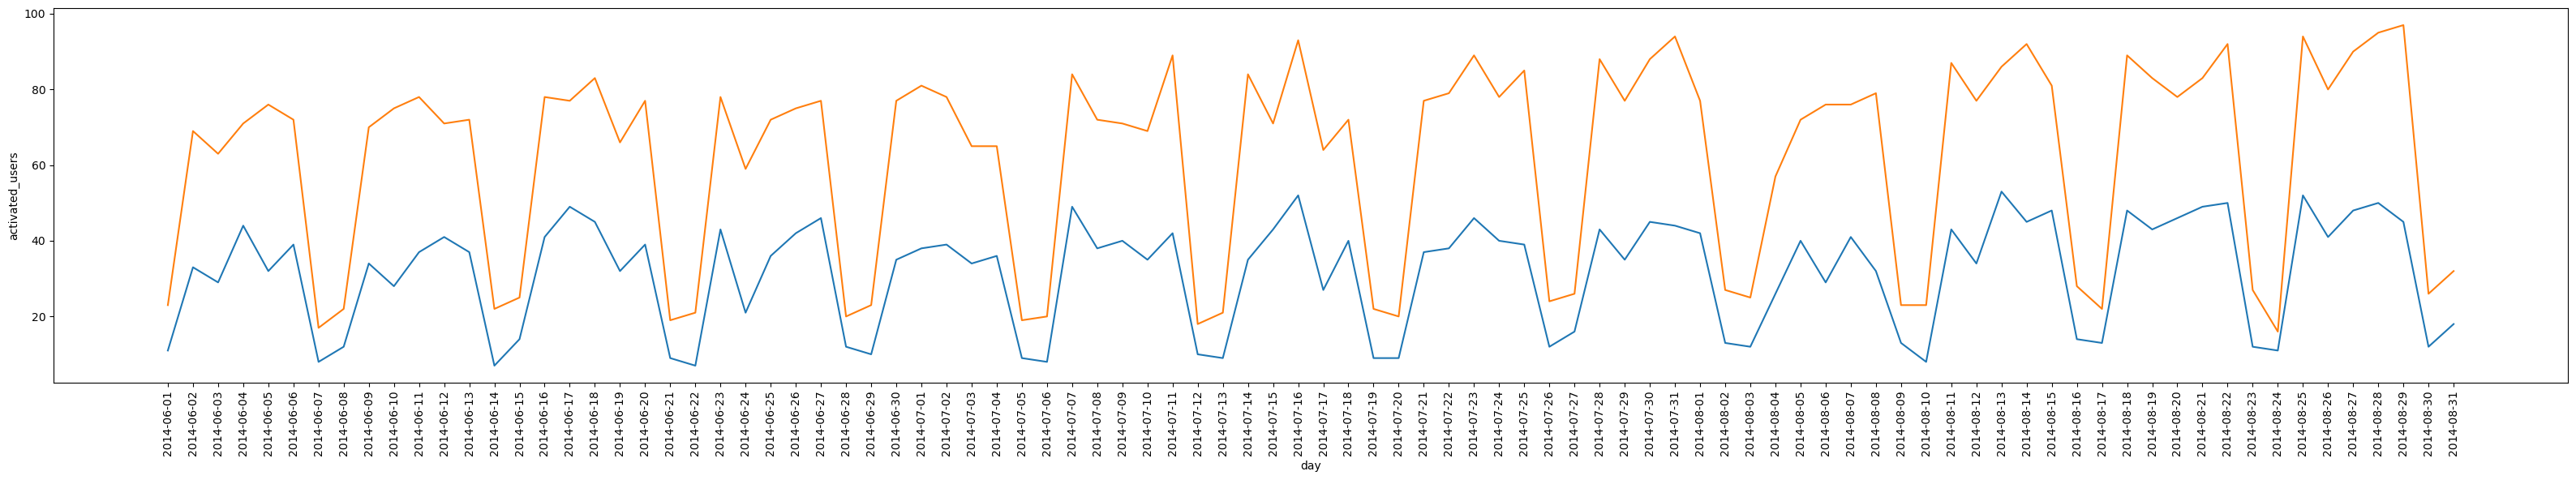

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(40,6))

sns.lineplot(x=user_df.day,y=user_df.activated_users )
sns.lineplot(x=user_df.day,y=user_df.all_users )

plt.xticks(rotation=90)
plt.show()

- 전 기간에서 신규가입자의 패턴은 비슷하다.
  

# 1-2. 신규 가입자 (주별)

In [15]:
query = " SELECT * ,CASE WHEN activated_at IS NOT NULL THEN 1 ELSE NULL END AS activated_cnt \
        FROM users \
        WHERE created_at >= '2014-06-01' AND created_at < '2014-09-01' "

user_week_df = execute_query(connection, query)
user_week_df


,user_id,created_at,company_id,language,activated_at,state,activated_cnt
0,13365.0,2014-06-01 15:45:09,8558.0,german,2014-06-01 15:46:48,active,1.0
1,13366.0,2014-06-01 21:03:31,32.0,german,2014-06-01 21:05:06,active,1.0
2,13367.0,2014-06-01 15:19:02,5475.0,spanish,2014-06-01 15:20:28,active,1.0
3,13368.0,2014-06-01 18:46:47,5930.0,spanish,None,pending,NaN
4,13369.0,2014-06-01 14:40:36,7.0,korean,2014-06-01 14:42:14,active,1.0
...,...,...,...,...,...,...,...
5696,19061.0,2014-08-31 13:21:16,2156.0,chinese,2014-08-31 13:22:50,active,1.0
5697,19062.0,2014-08-31 19:21:23,7520.0,spanish,None,pending,NaN
5698,19063.0,2014-08-31 07:10:41,72.0,spanish,2014-08-31 07:12:09,active,1.0
5699,19064.0,2014-08-31 17:45:18,2.0,english,None,pending,NaN


In [76]:
query = " SELECT * \
            FROM ( \
                SELECT activated_at,\
                    DATE_FORMAT(created_at, '%Y-%m-%d') as DATE, \
                    user_id, \
                    CASE WHEN activated_at IS NOT NULL THEN 1 ELSE NULL END AS activated_cnt, \
                    DAYOFWEEK(created_at)+5 as dow \
                FROM users \
                WHERE created_at >= '2014-06-01' AND created_at < '2014-09-01' \
                AND state = 'active' \
            ) z \
            GROUP BY ;"

user_week_df = execute_query(connection, query)
user_week_df


,activated_at,DATE,user_id,activated_cnt,dow,start_of_week
0,2014-06-01 15:46:48,2014-06-01,13365.0,1,6,2014-05-26
1,2014-06-01 21:05:06,2014-06-01,13366.0,1,6,2014-05-26
2,2014-06-01 15:20:28,2014-06-01,13367.0,1,6,2014-05-26
3,2014-06-01 14:42:14,2014-06-01,13369.0,1,6,2014-05-26
4,2014-06-01 09:54:08,2014-06-01,13372.0,1,6,2014-05-26
...,...,...,...,...,...,...
2896,2014-08-31 16:36:56,2014-08-31,19056.0,1,6,2014-08-25
2897,2014-08-31 19:53:43,2014-08-31,19059.0,1,6,2014-08-25
2898,2014-08-31 12:20:48,2014-08-31,19060.0,1,6,2014-08-25
2899,2014-08-31 13:22:50,2014-08-31,19061.0,1,6,2014-08-25


In [78]:
user_group_df = user_week_df.groupby(['start_of_week']).sum('activated_cnt')
user_group_df


,user_id,activated_cnt,dow
start_of_week,,,
2014-05-26,2658149.0,196,1770
2014-06-02,2736857.0,196,1768
2014-06-09,3290894.0,229,2025
2014-06-16,3064395.0,207,1905
2014-06-23,3056409.0,201,1804
2014-06-30,3464841.0,222,1987
2014-07-07,3448881.0,215,1929
2014-07-14,3641747.0,221,2004
2014-07-21,4031468.0,238,2140


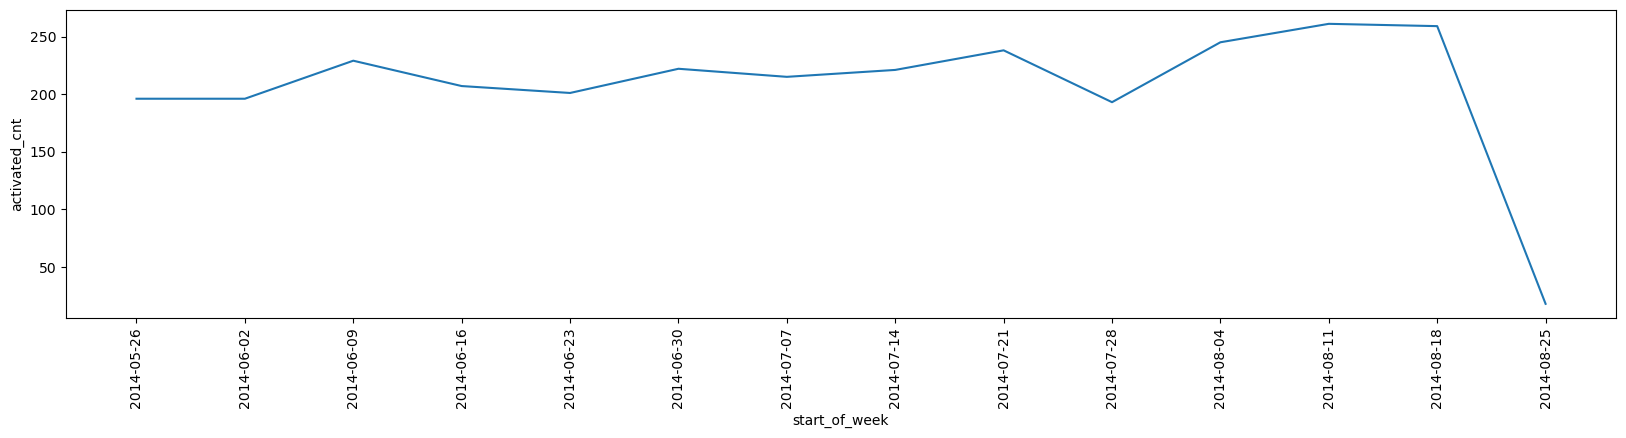

In [79]:
plt.figure(figsize=(20,4))

sns.lineplot(x=user_group_df.index,y=user_group_df.activated_cnt )

plt.xticks(rotation=90)
plt.show()

In [ ]:
user_week_df['created_at'] = user_week_df['created_at'].dt.date
user_week_df['start_of_week'] = user_week_df['created_at'] - pd.to_timedelta(user_week_df['created_at'].apply(lambda x: x.weekday()), unit='D')

user_week_df

In [63]:
user_week_df['created_at'] = pd.to_datetime(user_week_df['created_at'], format='%Y-%m-%d %H:%M:%S')
user_week_df['created_at'] = user_week_df['created_at'].dt.date
user_week_df['start_of_week'] = user_week_df['created_at'] - pd.to_timedelta(user_week_df['created_at'].apply(lambda x: x.weekday()), unit='D')

user_week_df

C:\Users\TEMP\AppData\Roaming\Python\Python39\site-packages\pandas\core\arrays\datetimelike.py:1187: PerformanceWarning: Adding/subtracting object-dtype array to TimedeltaArray not vectorized
  warnings.warn(


,user_id,created_at,company_id,language,activated_at,state,activated_cnt,start_of_week
0,13365.0,2014-06-01,8558.0,german,2014-06-01 15:46:48,active,1.0,2014-05-26
1,13366.0,2014-06-01,32.0,german,2014-06-01 21:05:06,active,1.0,2014-05-26
2,13367.0,2014-06-01,5475.0,spanish,2014-06-01 15:20:28,active,1.0,2014-05-26
3,13368.0,2014-06-01,5930.0,spanish,None,pending,NaN,2014-05-26
4,13369.0,2014-06-01,7.0,korean,2014-06-01 14:42:14,active,1.0,2014-05-26
...,...,...,...,...,...,...,...,...
5696,19061.0,2014-08-31,2156.0,chinese,2014-08-31 13:22:50,active,1.0,2014-08-25
5697,19062.0,2014-08-31,7520.0,spanish,None,pending,NaN,2014-08-25
5698,19063.0,2014-08-31,72.0,spanish,2014-08-31 07:12:09,active,1.0,2014-08-25
5699,19064.0,2014-08-31,2.0,english,None,pending,NaN,2014-08-25


In [64]:
user_week_group_df = user_week_df[['start_of_week','activated_cnt']].groupby(['start_of_week']).sum('activated_cnt')
user_week_group_df

,activated_cnt
start_of_week,
2014-05-26,11.0
2014-06-02,197.0
2014-06-09,198.0
2014-06-16,222.0
2014-06-23,210.0
2014-06-30,199.0
2014-07-07,223.0
2014-07-14,215.0
2014-07-21,228.0


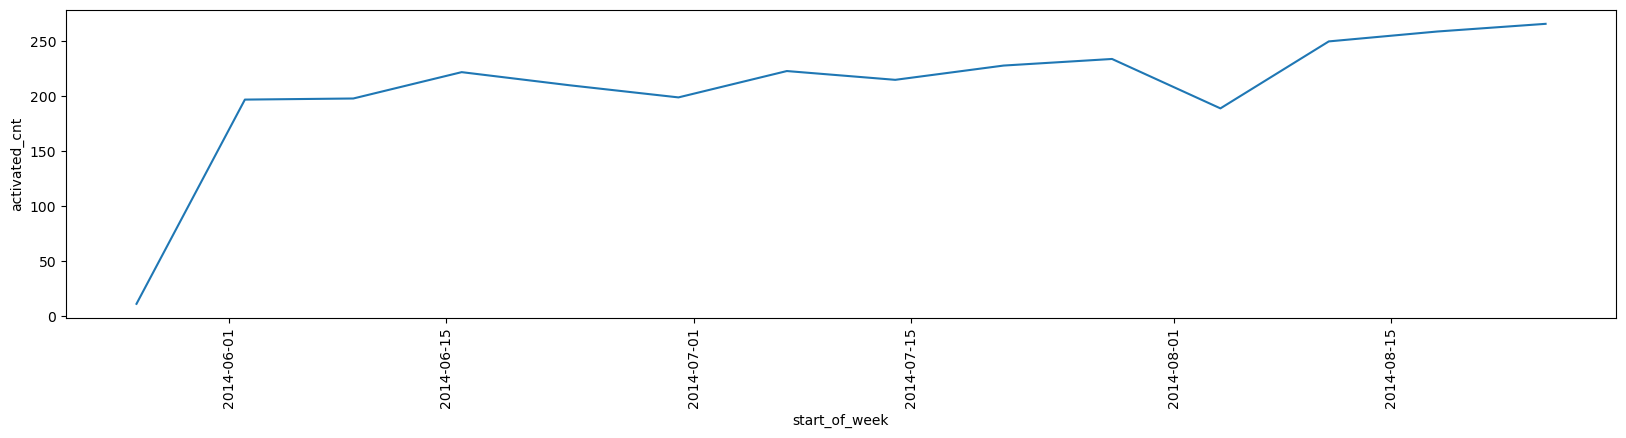

In [65]:
plt.figure(figsize=(20,4))

sns.lineplot(x=user_week_group_df.index,y=user_week_group_df.activated_cnt )

plt.xticks(rotation=90)
plt.show()

- 주별로 신규 가입자를 분석해보니, 2014년 7월 말쯤 ~ 2014년 8월 5일쯤까지 신규 유저 감소가 보인다.
- 2014-07말 ~ 2014-08초까지 유저 감소 원인을 파악해야 한다.

# 2. 코호트별 WAU 분석
- 기존 사용자를 분석해보자.
- `가입 시기`에 따라 user를 나눠보자.
- 예) 1.1~1.15일에 가입한 user를 group1로, 1.16~1.30에 가입한 user를 group2로 보는 것.

In [101]:
# 2014.05~ 2014.08에로그인을 했던 유저들
query1 = " SELECT * \
            FROM users u \
            JOIN events e ON u.user_id = e.user_id \
            AND e.event_type = 'engagement' \
            AND  e.event_name = 'login' \
            AND e.occurred_at >= '2014-05-01' AND e.occurred_at < '2014-09-01' \
            WHERE u.state = 'active'"
test_df = execute_query(connection, query1)
test_df

,user_id,created_at,company_id,language,activated_at,state,user_id,occurred_at,event_type,event_name,location,device,user_type
0,10522.0,2014-04-04 16:48:03,1147.0,japanese,2014-04-04 16:49:36,active,10522.0,2014-05-02 11:02:39,engagement,login,Japan,dell inspiron notebook,3.0
1,10612.0,2014-04-07 13:57:30,11066.0,english,2014-04-07 13:58:55,active,10612.0,2014-05-01 09:59:46,engagement,login,Netherlands,iphone 5,1.0
2,10736.0,2014-04-09 09:37:56,1532.0,german,2014-04-09 09:39:20,active,10736.0,2014-05-09 17:52:45,engagement,login,Austria,iphone 4s,2.0
3,10965.0,2014-04-14 15:17:49,5086.0,english,2014-04-14 15:19:08,active,10965.0,2014-05-15 13:52:59,engagement,login,Finland,windows surface,3.0
4,11020.0,2014-04-15 00:32:33,11365.0,japanese,2014-04-15 00:34:12,active,11020.0,2014-05-08 09:15:35,engagement,login,Japan,macbook air,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
38605,18806.0,2014-08-27 19:37:55,4583.0,english,2014-08-27 19:39:37,active,18806.0,2014-08-31 19:41:20,engagement,login,Greece,lenovo thinkpad,3.0
38606,18809.0,2014-08-27 22:58:21,13058.0,arabic,2014-08-27 22:59:36,active,18809.0,2014-08-31 23:01:15,engagement,login,Pakistan,dell inspiron notebook,3.0
38607,18813.0,2014-08-27 18:41:47,10766.0,english,2014-08-27 18:43:26,active,18813.0,2014-08-31 18:44:53,engagement,login,United Kingdom,nexus 10,2.0
38608,18814.0,2014-08-27 12:10:29,17.0,japanese,2014-08-27 12:12:05,active,18814.0,2014-08-31 12:13:31,engagement,login,Japan,dell inspiron notebook,3.0


In [155]:
# 2014.05~ 2014.08에로그인을 했던 유저들
## user_age = user 가입일 수
## age_at_event = event가 발생했을 당시 user 가입일 수 
query2 = " SELECT *, CASE WHEN user_age >= 70 THEN '10+ weeks' \
                    WHEN user_age BETWEEN 63 AND 69 THEN '9 weeks' \
                    WHEN user_age BETWEEN 56 AND 62 THEN '8 weeks' \
                    WHEN user_age BETWEEN 49 AND 55 THEN '7 weeks' \
                    WHEN user_age BETWEEN 42 AND 48 THEN '6 weeks' \
                    WHEN user_age BETWEEN 35 AND 41 THEN '5 weeks' \
                    WHEN user_age BETWEEN 28 AND 34 THEN '4 weeks' \
                    WHEN user_age BETWEEN 21 AND 27 THEN '3 weeks' \
                    WHEN user_age BETWEEN 14 AND 20 THEN '2 weeks' \
                    WHEN user_age BETWEEN 7 AND 13 THEN '1 week' \
                ELSE 'less than a week' \
                END AS week_cnt \
            FROM \
                (SELECT e.occurred_at, u.user_id,\
                    DATEDIFF('2014-09-01', u.activated_at) as user_age, \
                    DATEDIFF(e.occurred_at, u.activated_at ) as age_at_event \
                FROM users u \
                JOIN events e ON u.user_id = e.user_id \
                AND e.event_type = 'engagement' \
                AND  e.event_name = 'login' \
                AND e.occurred_at >= '2014-05-01' AND e.occurred_at < '2014-09-01' \
                WHERE u.state = 'active') z"
test_df = execute_query(connection, query2)
test_df

,occurred_at,user_id,user_age,age_at_event,week_cnt
0,2014-05-02 11:02:39,10522.0,150,28,10+ weeks
1,2014-05-01 09:59:46,10612.0,147,24,10+ weeks
2,2014-05-09 17:52:45,10736.0,145,30,10+ weeks
3,2014-05-15 13:52:59,10965.0,140,31,10+ weeks
4,2014-05-08 09:15:35,11020.0,139,23,10+ weeks
...,...,...,...,...,...
38605,2014-08-31 19:41:20,18806.0,5,4,less than a week
38606,2014-08-31 23:01:15,18809.0,5,4,less than a week
38607,2014-08-31 18:44:53,18813.0,5,4,less than a week
38608,2014-08-31 12:13:31,18814.0,5,4,less than a week


In [156]:
test_df['occurred_at'] = pd.to_datetime(test_df['occurred_at'], format='%Y-%m-%d %H:%M:%S')
test_df['occurred_at'] = test_df['occurred_at'].dt.date
test_df['start_of_week'] = test_df['occurred_at'] - pd.to_timedelta(test_df['occurred_at'].apply(lambda x: x.weekday()), unit='D')
test_df

C:\Users\TEMP\AppData\Roaming\Python\Python39\site-packages\pandas\core\arrays\datetimelike.py:1187: PerformanceWarning: Adding/subtracting object-dtype array to TimedeltaArray not vectorized
  warnings.warn(


,occurred_at,user_id,user_age,age_at_event,week_cnt,start_of_week
0,2014-05-02,10522.0,150,28,10+ weeks,2014-04-28
1,2014-05-01,10612.0,147,24,10+ weeks,2014-04-28
2,2014-05-09,10736.0,145,30,10+ weeks,2014-05-05
3,2014-05-15,10965.0,140,31,10+ weeks,2014-05-12
4,2014-05-08,11020.0,139,23,10+ weeks,2014-05-05
...,...,...,...,...,...,...
38605,2014-08-31,18806.0,5,4,less than a week,2014-08-25
38606,2014-08-31,18809.0,5,4,less than a week,2014-08-25
38607,2014-08-31,18813.0,5,4,less than a week,2014-08-25
38608,2014-08-31,18814.0,5,4,less than a week,2014-08-25


In [157]:
test_df = test_df.drop_duplicates(['occurred_at','user_id'])
print(test_df.shape)

(34841, 6)


In [158]:
test_df2 = test_df.groupby(['start_of_week','week_cnt'])[['user_id']].nunique().reset_index()
test_df2

,start_of_week,week_cnt,user_id
0,2014-04-28,10+ weeks,701
1,2014-05-05,10+ weeks,1054
2,2014-05-12,10+ weeks,1094
3,2014-05-19,10+ weeks,1147
4,2014-05-26,10+ weeks,1113
...,...,...,...
68,2014-08-25,6 weeks,24
69,2014-08-25,7 weeks,19
70,2014-08-25,8 weeks,19
71,2014-08-25,9 weeks,17


In [284]:
# 'variable' 열을 행 인덱스로, 'value' 열을 새로운 열로 변환
pivot_df = test_df2.pivot(index='start_of_week', columns='week_cnt', values='user_id')

# 결과 확인
pivot_df


week_cnt,1 week,10+ weeks,2 weeks,3 weeks,4 weeks,5 weeks,6 weeks,7 weeks,8 weeks,9 weeks,less than a week
start_of_week,,,,,,,,,,,
2014-04-28,NaN,701.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-05-05,NaN,1054.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-05-12,NaN,1094.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-05-19,NaN,1147.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-05-26,NaN,1113.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-06-02,NaN,1173.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-06-09,NaN,1219.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-06-16,NaN,1262.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-06-23,NaN,1082.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,167.0,NaN


In [285]:
pivot_df = pivot_df[[ '10+ weeks', '9 weeks','8 weeks','7 weeks','6 weeks','5 weeks','4 weeks','3 weeks', '2 weeks','1 week','less than a week']]
# pivot_df.reset_index(inplace=True)
pivot_df

week_cnt,10+ weeks,9 weeks,8 weeks,7 weeks,6 weeks,5 weeks,4 weeks,3 weeks,2 weeks,1 week,less than a week
start_of_week,,,,,,,,,,,
2014-04-28,701.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-05-05,1054.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-05-12,1094.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-05-19,1147.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-05-26,1113.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-06-02,1173.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-06-09,1219.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-06-16,1262.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-06-23,1082.0,167.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


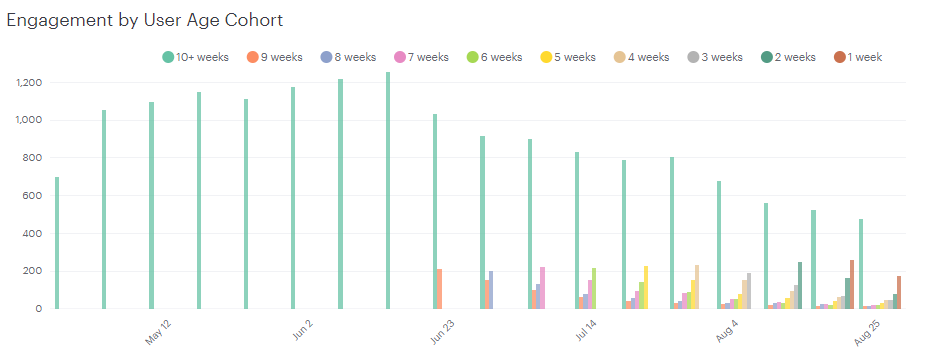

In [288]:
pivot_df.reset_index(inplace=True)
pivot_df.columns

Index(['start_of_week', '10+ weeks', '9 weeks', '8 weeks', '7 weeks',
       '6 weeks', '5 weeks', '4 weeks', '3 weeks', '2 weeks', '1 week',
       'less than a week'],
      dtype='object', name='week_cnt')

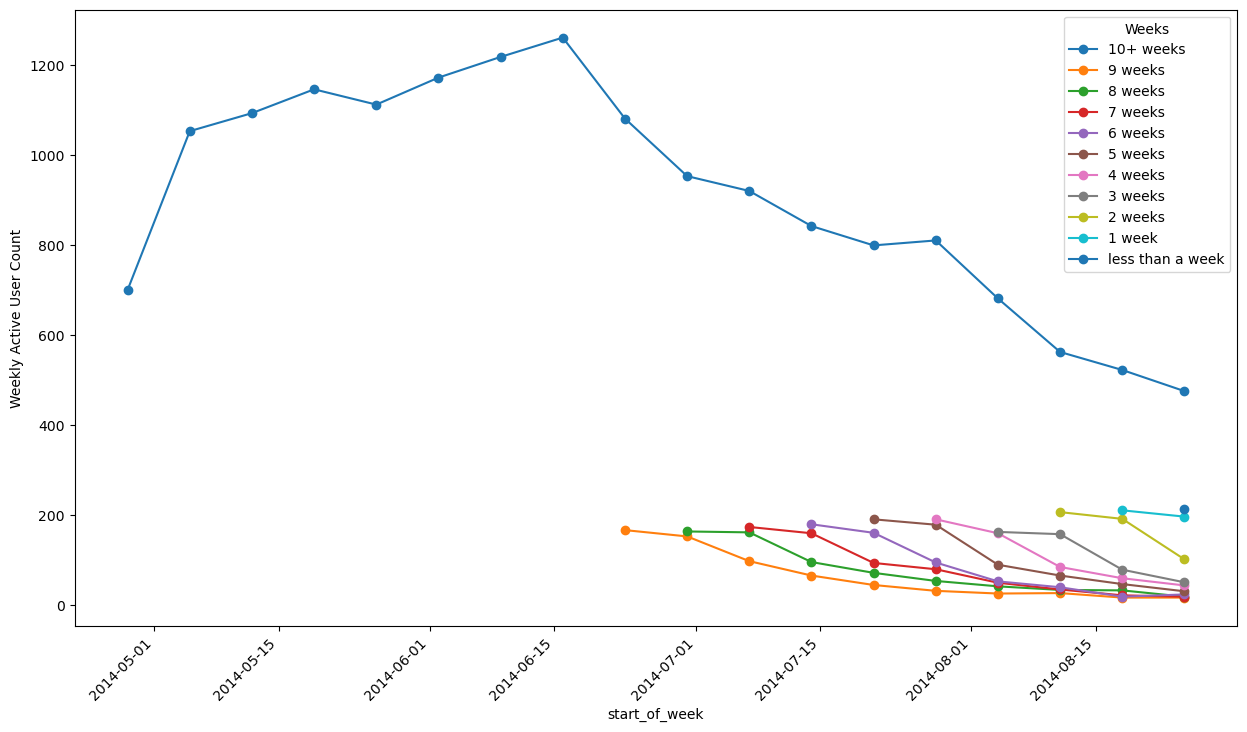

In [289]:

import matplotlib.pyplot as plt


# 그래프 크기 설정
plt.figure(figsize=(15, 8))

# 각 컬럼에 대해 하나의 선 그래프 그리기
for col in pivot_df.columns[1:]:  # 'start_of_week' 제외
    plt.plot(pivot_df['start_of_week'], pivot_df[col], label=col, marker='o')

# x축 레이블과 범례 추가
plt.xlabel('start_of_week')
plt.ylabel('Weekly Active User Count')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Weeks')

# 그래프 표시
plt.show()


- 가입으로부터 시간이 지날 수록 Active User가 감소하는 것은 Retention 차트의 전형적인 패턴이다.
  - less than a week ~ 9 weeks까지의 그룹은 일반적인 retention 차트의 특성을 보인다.

- 그러나, 10+ weeks를 주목해야 한다.
  - 10+ weeks 그룹: 10주 이전에 가입한 그룹. 여기에는 10주 전, 11주 전, 12주 전..등등 사용자 모두 포함
  - 따라서 2014-06월 중순까지 활동이 꾸준히 상승 (가입자가 늘고있기 때문에)
  - 이들은 2016-06-15일부터활동이 줄어든다. (일반적인 패턴)
  - 근데 2014-08월 이전까지 다시 사용량이 상승하다가 8월 이후 급격하게 감소한다.

- 결론: older user들로부터 이러한 WAU 감소가 나타나는 듯 하다.
  - 즉, WAU의 감소가 마케팅 트래픽으로 인한 spike나 서치엔진의 랭킹 변화나 사이트 차단과 같은 new traffic에 영향을 주는 요소들과는 관계가 없다는 것이다.
  - 이젠 다양한 device type을 살펴보자.

# 3. 디바이스별 WAU

In [376]:
query = " SELECT e.user_id,e.occurred_at, \
            CASE \
              WHEN device IN ('macbook pro', 'lenovo thinkpad', 'macbook air', 'dell inspiron notebook', 'asus chromebook', 'dell inspiron desktop', 'acer aspire notebook', 'hp pavilion desktop', 'acer aspire desktop', 'mac mini') THEN 'computer' \
              WHEN device IN ('iphone 5', 'samsung galaxy s4', 'nexus 5', 'iphone 5s', 'iphone 4s', 'nokia lumia 635', 'htc one', 'samsung galaxy note', 'amazon fire phone') THEN 'phone' \
              WHEN device IN ('ipad air', 'nexus 7', 'ipad mini', 'nexus 10', 'kindle fire', 'windows surface', 'samsung galaxy tablet','samsumg galaxy tablet') THEN 'tablet'\
              ELSE 'NONE'\
            END AS 'device_type'\
    FROM events e JOIN users u ON e.user_id = u.user_id\
    AND e.event_type = 'engagement' AND e.event_name = 'login'\
      AND e.occurred_at >= '2014-05-01' AND e.occurred_at < '2014-09-01' \
              WHERE u.state = 'active';"
test_df = execute_query(connection, query)
test_df.head()

,user_id,occurred_at,device_type
0,10522.0,2014-05-02 11:02:39,computer
1,10612.0,2014-05-01 09:59:46,phone
2,10736.0,2014-05-09 17:52:45,phone
3,10965.0,2014-05-15 13:52:59,tablet
4,11020.0,2014-05-08 09:15:35,computer


In [377]:
test_df['occurred_at'] = pd.to_datetime(test_df['occurred_at'], format='%Y-%m-%d %H:%M:%S')
test_df['occurred_at'] = test_df['occurred_at'].dt.date
test_df['start_of_week'] = test_df['occurred_at'] - pd.to_timedelta(test_df['occurred_at'].apply(lambda x: x.weekday()), unit='D')
test_df

C:\Users\TEMP\AppData\Roaming\Python\Python39\site-packages\pandas\core\arrays\datetimelike.py:1187: PerformanceWarning: Adding/subtracting object-dtype array to TimedeltaArray not vectorized
  warnings.warn(


,user_id,occurred_at,device_type,start_of_week
0,10522.0,2014-05-02,computer,2014-04-28
1,10612.0,2014-05-01,phone,2014-04-28
2,10736.0,2014-05-09,phone,2014-05-05
3,10965.0,2014-05-15,tablet,2014-05-12
4,11020.0,2014-05-08,computer,2014-05-05
...,...,...,...,...
38605,18806.0,2014-08-31,computer,2014-08-25
38606,18809.0,2014-08-31,computer,2014-08-25
38607,18813.0,2014-08-31,tablet,2014-08-25
38608,18814.0,2014-08-31,computer,2014-08-25


In [378]:
test_df.drop_duplicates(inplace=True)
test_df.shape

(36464, 4)

In [386]:
test_group_df = test_df.groupby(['device_type','start_of_week'])[['user_id']].nunique('user_id')
test_group_df

user_id
device_type start_of_week         
computer    2014-04-28         415
            2014-05-05         712
            2014-05-12         715
            2014-05-19         758
            2014-05-26         716
            2014-06-02         791
            2014-06-09         798
            2014-06-16         812
            2014-06-23         834
            2014-06-30         805
            2014-07-07         877
            2014-07-14         900
            2014-07-21         903
            2014-07-28         951
            2014-08-04         913
            2014-08-11         886
            2014-08-18         875
            2014-08-25         864
phone       2014-04-28         281
            2014-05-05         461
            2014-05-12         481
            2014-05-19         526
            2014-05-26         500
            2014-06-02         505
            2014-06-09         545
            2014-06-16         541
            2014-06-23         526
            2014-06-30         578
            2014-07-07         591
            2014-07-14         578
            2014-07-21         601
            2014-07-28         588
            2014-08-04         491
            2014-08-11         438
            2014-08-18         428
            2014-08-25         441
tablet      2014-04-28         111
            2014-05-05         187
            2014-05-12         197
            2014-05-19         190
            2014-05-26         182
            2014-06-02         208
            2014-06-09         209
            2014-06-16         238
            2014-06-23         222
            2014-06-30         230
            2014-07-07         242
            2014-07-14         227
            2014-07-21         231
            2014-07-28         250
            2014-08-04         173
            2014-08-11         159
            2014-08-18         157
            2014-08-25         163

In [392]:
test_group_df.reset_index(inplace=True)
test_pivot_df = test_group_df.pivot(index='start_of_week', columns='device_type', values='user_id')
test_pivot_df['WAU'] = test_pivot_df['computer']+test_pivot_df['phone']+test_pivot_df['tablet']
test_pivot_df
# test_group_df

device_type,computer,phone,tablet,WAU
start_of_week,,,,
2014-04-28,415,281,111,807
2014-05-05,712,461,187,1360
2014-05-12,715,481,197,1393
2014-05-19,758,526,190,1474
2014-05-26,716,500,182,1398
2014-06-02,791,505,208,1504
2014-06-09,798,545,209,1552
2014-06-16,812,541,238,1591
2014-06-23,834,526,222,1582


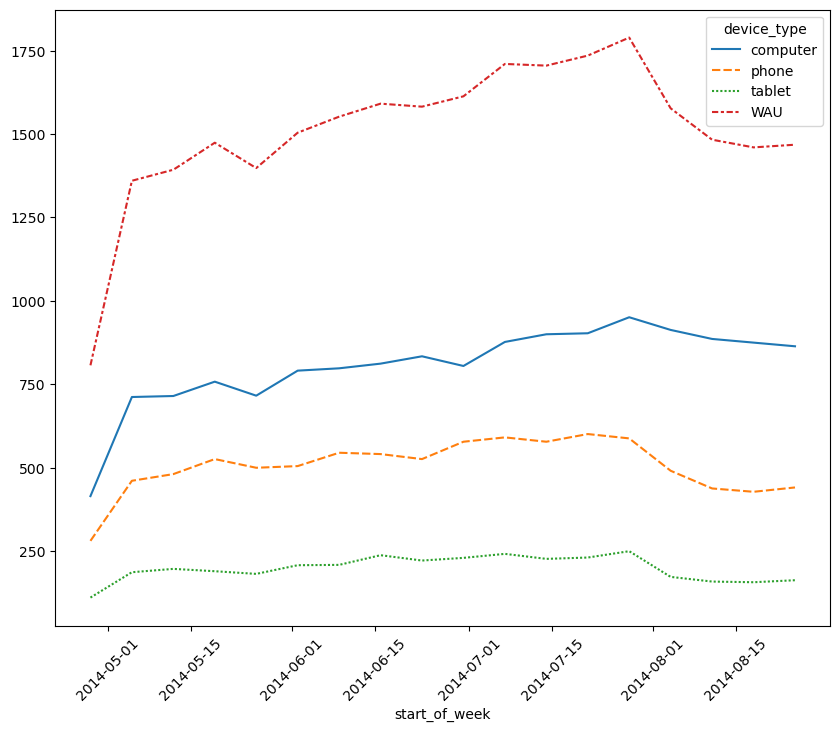

In [395]:
plt.figure(figsize=(10,8))
sns.lineplot(data=test_pivot_df)
plt.xticks(rotation=45)
plt.show()

- phone, tablet에서 2014-08-01 즈음 사용량이 감소하고 있다.
- 모바일 앱에 문제가 생겼을 수도 있다. 관련 부서에 물어봐야 한다.

# 4. email 분석
- 2번 분석에서 old user의 사용량 감소가 2014-08월 WAU 감소의 원인이었다.
- old user는 마케팅보다는 email newsletter로 들어올 가능성이 크다.
- 따라서 email 유입원에 따라 분석을 진행하겠다.

In [403]:
query = " SELECT *, CASE WHEN action = 'sent_weekly_digest' THEN 'weekly_emails' \
                        WHEN action = 'email_open' THEN 'email_opens' \
                        WHEN action = 'email_clickthrough' THEN 'email_clickthrough' \
                        WHEN action  = 'sent_reengagement_email' THEN 'reengagement_emails' \
                    ELSE 'NONE' END AS type \
            FROM emails "

df = execute_query(connection, query)
df.head()

,user_id,occurred_at,action,user_type,type
0,0.0,2014-05-06 09:30:00,sent_weekly_digest,1.0,weekly_emails
1,0.0,2014-05-13 09:30:00,sent_weekly_digest,1.0,weekly_emails
2,0.0,2014-05-20 09:30:00,sent_weekly_digest,1.0,weekly_emails
3,0.0,2014-05-27 09:30:00,sent_weekly_digest,1.0,weekly_emails
4,0.0,2014-06-03 09:30:00,sent_weekly_digest,1.0,weekly_emails


In [404]:
df['occurred_at'] = pd.to_datetime(df['occurred_at'], format = '%Y-%m-%d %H:%M:%S')
df['occurred_at'] = df['occurred_at'].dt.date
df['start_weekday'] = df['occurred_at'] - pd.to_timedelta(df['occurred_at'].apply(lambda x: x.weekday()),unit='D')
df

C:\Users\TEMP\AppData\Roaming\Python\Python39\site-packages\pandas\core\arrays\datetimelike.py:1187: PerformanceWarning: Adding/subtracting object-dtype array to TimedeltaArray not vectorized
  warnings.warn(


,user_id,occurred_at,action,user_type,type,start_weekday
0,0.0,2014-05-06,sent_weekly_digest,1.0,weekly_emails,2014-05-05
1,0.0,2014-05-13,sent_weekly_digest,1.0,weekly_emails,2014-05-12
2,0.0,2014-05-20,sent_weekly_digest,1.0,weekly_emails,2014-05-19
3,0.0,2014-05-27,sent_weekly_digest,1.0,weekly_emails,2014-05-26
4,0.0,2014-06-03,sent_weekly_digest,1.0,weekly_emails,2014-06-02
...,...,...,...,...,...,...
90384,18814.0,2014-08-31,email_open,3.0,email_opens,2014-08-25
90385,18814.0,2014-08-31,email_clickthrough,3.0,email_clickthrough,2014-08-25
90386,18815.0,2014-08-31,sent_reengagement_email,2.0,reengagement_emails,2014-08-25
90387,18815.0,2014-08-31,email_open,2.0,email_opens,2014-08-25


In [405]:
df.drop_duplicates()

,user_id,occurred_at,action,user_type,type,start_weekday
0,0.0,2014-05-06,sent_weekly_digest,1.0,weekly_emails,2014-05-05
1,0.0,2014-05-13,sent_weekly_digest,1.0,weekly_emails,2014-05-12
2,0.0,2014-05-20,sent_weekly_digest,1.0,weekly_emails,2014-05-19
3,0.0,2014-05-27,sent_weekly_digest,1.0,weekly_emails,2014-05-26
4,0.0,2014-06-03,sent_weekly_digest,1.0,weekly_emails,2014-06-02
...,...,...,...,...,...,...
90384,18814.0,2014-08-31,email_open,3.0,email_opens,2014-08-25
90385,18814.0,2014-08-31,email_clickthrough,3.0,email_clickthrough,2014-08-25
90386,18815.0,2014-08-31,sent_reengagement_email,2.0,reengagement_emails,2014-08-25
90387,18815.0,2014-08-31,email_open,2.0,email_opens,2014-08-25


In [412]:
group_df = df.groupby(['type','start_weekday']).nunique()[['user_id']]
# group_df
group_df.reset_index(inplace=True)
group_pivot_df = group_df.pivot(index='start_weekday', columns='type', values='user_id')
group_pivot_df

type,email_clickthrough,email_opens,reengagement_emails,weekly_emails
start_weekday,,,,
2014-04-28,187,332,98,908
2014-05-05,431,910,164,2602
2014-05-12,478,961,175,2665
2014-05-19,495,984,179,2733
2014-05-26,447,1008,179,2822
2014-06-02,483,972,199,2911
2014-06-09,527,1058,190,3003
2014-06-16,558,1144,234,3105
2014-06-23,517,1080,187,3207


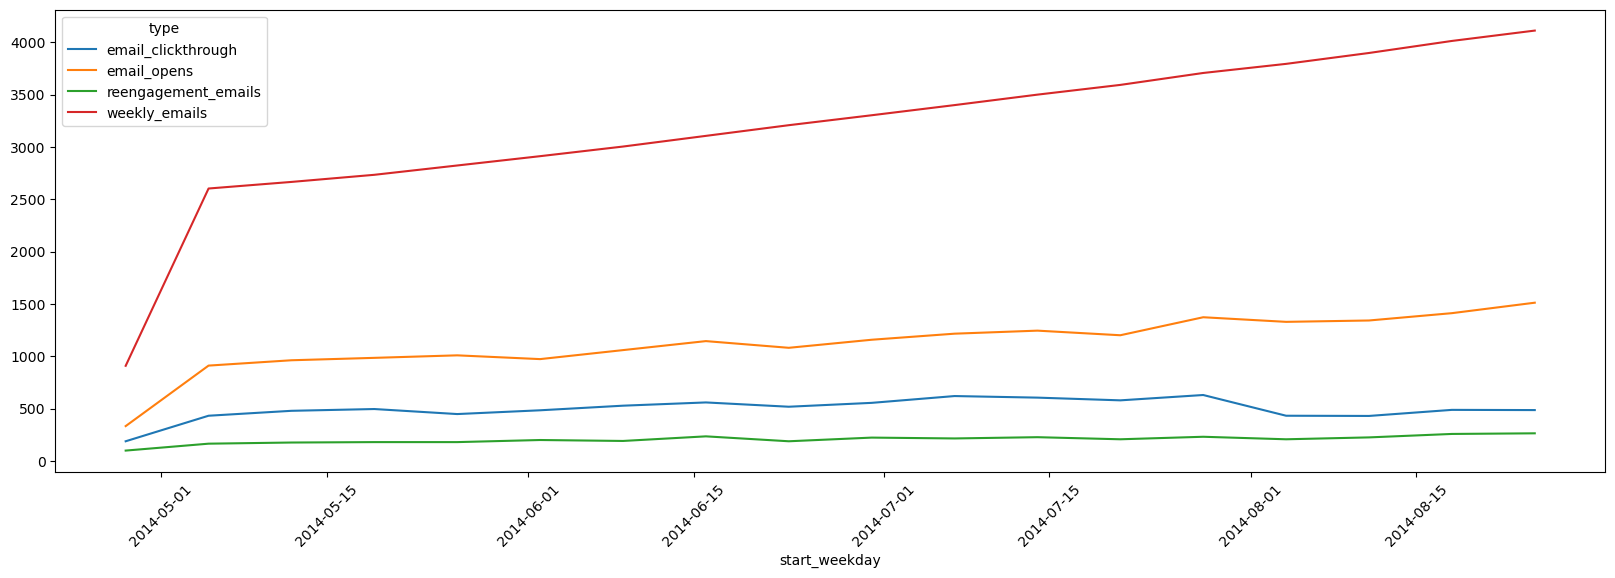

In [421]:
group_pivot_df.plot(figsize=(20,6))
plt.xticks(rotation=45)
plt.show()

- 7월말 ~ 8월초에 email_clickthrough가 감소했다.
- 사용자가 이메일을 수신하고 open하는 것까지는 문제가 없다. 그러나, 이메일 내부 링크를 통해 서비스에 접속한 유저가 감소했다.
- 이메일 내부 링크가 작동을 안할 수도 있다.

# 결론
2014-07말~ 2014-08초에 WAU가 감소한 이유는 아래와 같다.
- 1. 비교적 최근 가입한 user보단 old users 사이에서 사용량이 감소한다.
- 2. device 중 mobile(phone, tablet) user의 사용량이 감소했다.
- 3. digest email 내의 링크 클릭량이 감소했다. 링크에 문제가 있을 수도 있다.
- 